In [1]:
import sys
import os
import warnings
import random
from glob import glob
import cv2
import matplotlib.pyplot as plt
import shutil
import yaml
import albumentations as A
from ultralytics import YOLO
from IPython.display import FileLink
from transformers import CLIPProcessor, CLIPModel
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import clip
from tqdm.auto import tqdm
from collections import defaultdict


sys.stderr = sys.stdout
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

!pip install -q roboflow

from roboflow import Roboflow

rf = Roboflow(api_key="bFCeZjvdm1jyeb9ud2ak")

project = rf.workspace("waleed-azzi-o5bzp").project("wildfire-detection-3vcvr")

dataset = project.version(1).download("yolov5")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 35.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.1 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sigstore 3.6.1 requires rich~=13.0, but you have rich 14.0.0 which is incompatible.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.5, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
google-

E0000 00:00:1746026171.736434      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746026171.785837      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Saved 7531 samples to /kaggle/working/wildfire-detection--1/train_small


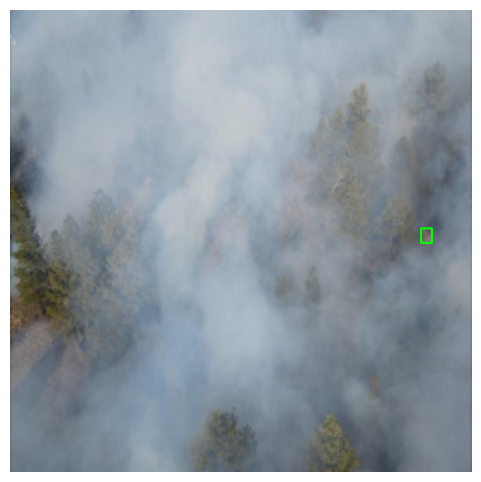

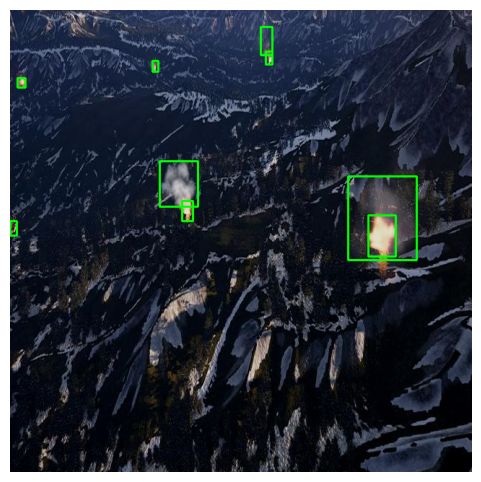

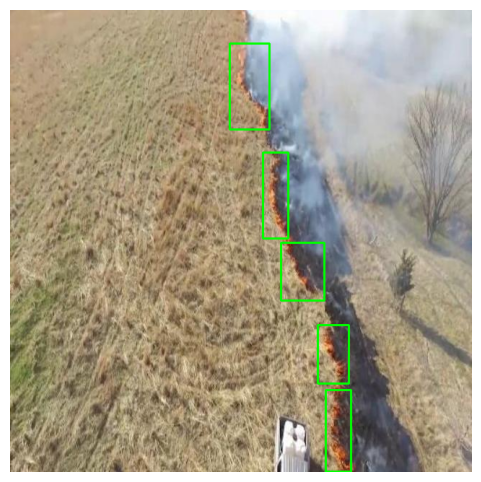

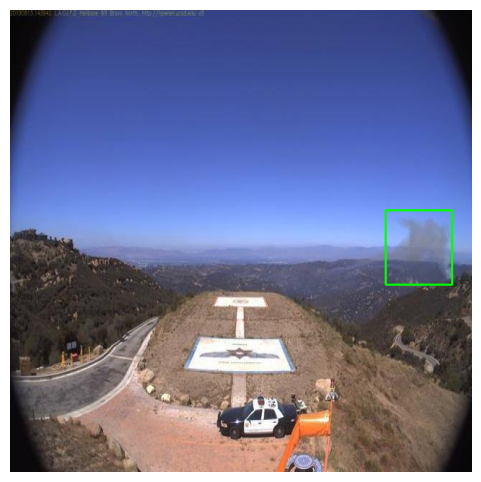

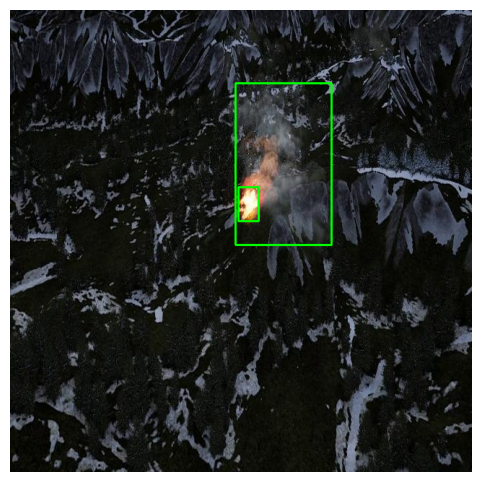

Saved 1215 samples to /kaggle/working/wildfire-detection--1/valid_small


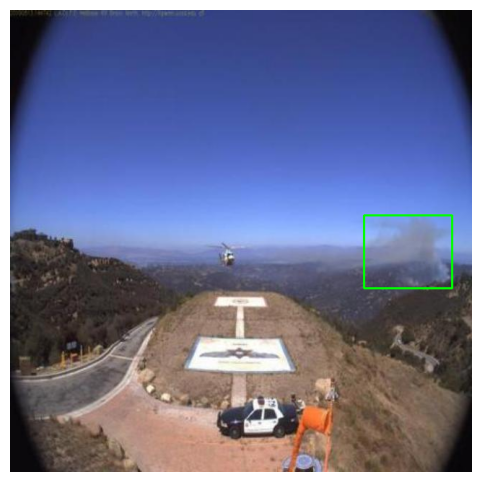

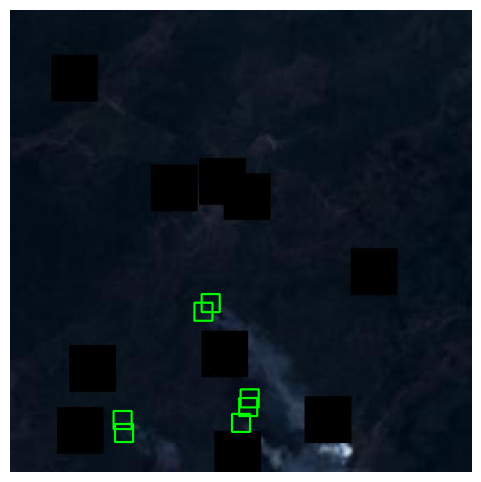

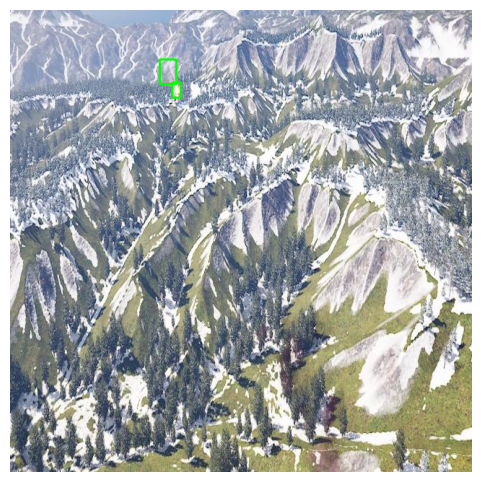

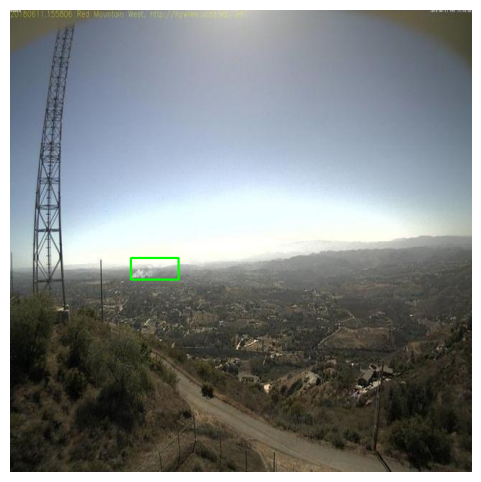

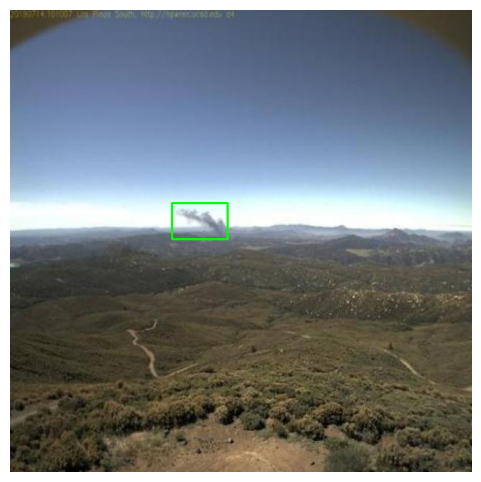

Saved 604 samples to /kaggle/working/wildfire-detection--1/test_small


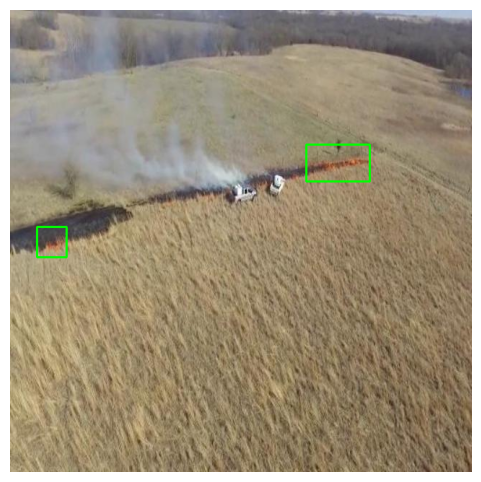

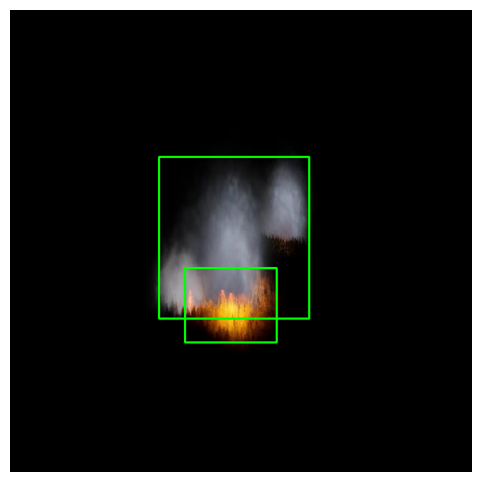

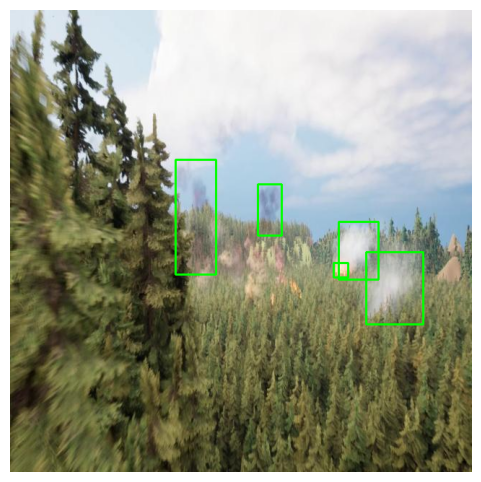

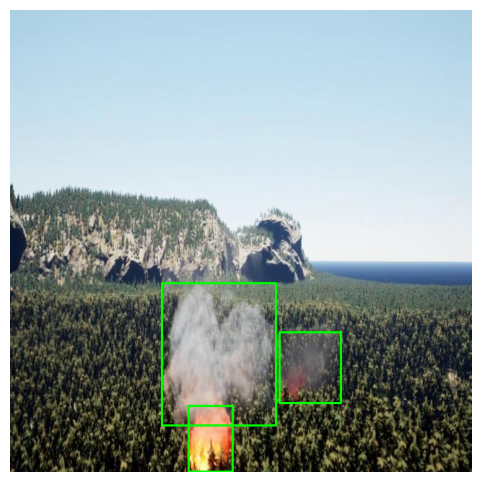

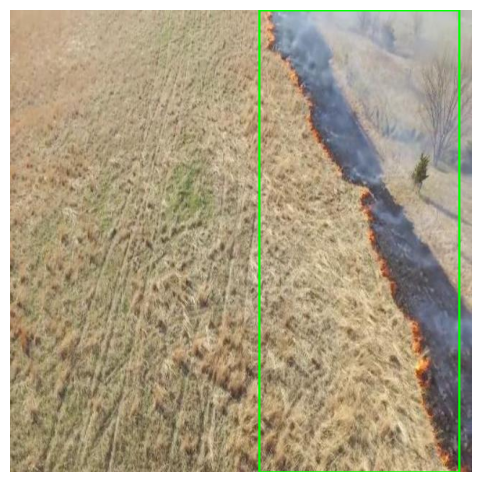

In [2]:
def display_yolo_image(img_path, lbl_path):

    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image: {img_path}")
        return
    h, w = img.shape[:2]
    if os.path.exists(lbl_path):
        with open(lbl_path) as f:
            for line in f:
                cls, x_c, y_c, bw, bh = map(float, line.split())
                x1 = int((x_c - bw/2) * w)
                y1 = int((y_c - bh/2) * h)
                x2 = int((x_c + bw/2) * w)
                y2 = int((y_c + bh/2) * h)
                cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
    else:
        cv2.putText(img, "NO FIRE", (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def sample_and_display(original_dir, sample_ratio=0.1, display_n=5, save_copy=False):

    img_dir = os.path.join(original_dir, "images")
    lbl_dir = os.path.join(original_dir, "labels")
    out_dir = original_dir + "_small"
    out_img = os.path.join(out_dir, "images")
    out_lbl = os.path.join(out_dir, "labels")

    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)
    os.makedirs(out_img, exist_ok=True)
    os.makedirs(out_lbl, exist_ok=True)

    all_imgs = glob(os.path.join(img_dir, "*.jpg"))
    k = max(1, int(len(all_imgs)*sample_ratio))
    chosen = random.sample(all_imgs, k)

    for img_path in chosen:
        fn = os.path.basename(img_path)
        lbl_path = os.path.join(lbl_dir, fn.replace(".jpg",".txt"))
        shutil.copy(img_path, out_img)
        if os.path.exists(lbl_path):
            shutil.copy(lbl_path, out_lbl)
        else:
            open(os.path.join(out_lbl, fn.replace(".jpg",".txt")), "w").close()

    print(f"Saved {len(chosen)} samples to {out_dir}")
    for img in chosen[:display_n]:
        display_yolo_image(img,
            os.path.join(out_lbl, os.path.basename(img).replace(".jpg",".txt")))

base_path = "/kaggle/working/wildfire-detection--1"
for split in ["train","valid","test"]:
    sample_and_display(os.path.join(base_path, split),
                       sample_ratio=1.0, display_n=5, save_copy=True)


In [3]:
yaml_path = "/kaggle/working/wildfire-detection--1/data.yaml"

try:
    with open(yaml_path, 'r') as file:
        data = yaml.safe_load(file)
    
    print("Class mappings:")
    for i, name in enumerate(data['names']):
        print(f"{i}: {name}")
    
    print("\nFull dataset config:")
    print(data)
except FileNotFoundError:
    print(f"Error: {yaml_path} not found!")
except Exception as e:
    print(f"Error reading YAML file: {e}")

Class mappings:
0: fire
1: smoke

Full dataset config:
{'names': ['fire', 'smoke'], 'nc': 2, 'roboflow': {'license': 'CC BY 4.0', 'project': 'wildfire-detection-3vcvr', 'url': 'https://universe.roboflow.com/waleed-azzi-o5bzp/wildfire-detection-3vcvr/dataset/1', 'version': 1, 'workspace': 'waleed-azzi-o5bzp'}, 'test': '../test/images', 'train': 'wildfire-detection--1/train/images', 'val': 'wildfire-detection--1/valid/images'}


In [4]:
!pip install ultralytics pyyaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [5]:
def create_subset(original_dir, subset_dir, sample_size=100):
    if os.path.exists(subset_dir):
        shutil.rmtree(subset_dir)

    os.makedirs(os.path.join(subset_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(subset_dir, 'labels'), exist_ok=True)

    img_files = glob(os.path.join(original_dir, 'images', '*.jpg'))
    annotated_imgs = [
        img for img in img_files
        if os.path.exists(img.replace('images', 'labels').replace('.jpg', '.txt'))
    ]

    sampled = random.sample(annotated_imgs, min(sample_size, len(annotated_imgs)))

    for img_path in sampled:

        shutil.copy(img_path, os.path.join(subset_dir, 'images'))

        label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')
        shutil.copy(label_path, os.path.join(subset_dir, 'labels'))

base_path = "/kaggle/working/wildfire-detection--1"

create_subset(os.path.join(base_path, 'train'), os.path.join(base_path, 'train_small'), 7000)
create_subset(os.path.join(base_path, 'valid'), os.path.join(base_path, 'valid_small'), 1050)
create_subset(os.path.join(base_path, 'test'), os.path.join(base_path, 'test_small'), 700)

def print_dataset_sizes(base_path):
    dirs = ['train', 'train_small', 'valid', 'valid_small']
    for d in dirs:
        img_dir = os.path.join(base_path, d, 'images')
        lbl_dir = os.path.join(base_path, d, 'labels')

        num_imgs = len([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        num_lbls = len(glob(os.path.join(lbl_dir, '*.txt')))

        print(f"\nContents of '{os.path.join(base_path, d)}':")
        print(f"  Images: {num_imgs}")
        print(f"  Labels: {num_lbls}")

        if 'small' in d:
            expected = 550 if 'train' in d else 55
            if num_imgs != expected or num_lbls != expected:
                print(f"  ❌ Error: Expected {expected}, but got {num_imgs} images and {num_lbls} labels.")
            else:
                print("  ✅ Subset size correct.")

base_path = "/kaggle/working/wildfire-detection--1"
nofire_input_path = "/kaggle/input/nofire/nofire" 
nofire_output_path = os.path.join(base_path, "test_small", "images")
label_output_path = os.path.join(base_path, "test_small", "labels")

os.makedirs(nofire_output_path, exist_ok=True)
os.makedirs(label_output_path, exist_ok=True)

all_nofire_images = [f for f in os.listdir(nofire_input_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
selected_nofire_images = random.sample(all_nofire_images, min(700, len(all_nofire_images)))

for image_name in selected_nofire_images:
    src_img = os.path.join(nofire_input_path, image_name)
    dst_img = os.path.join(nofire_output_path, image_name)

    shutil.copy(src_img, dst_img)

    label_name = os.path.splitext(image_name)[0] + ".txt"
    dst_lbl = os.path.join(label_output_path, label_name)
    open(dst_lbl, 'w').close()

print(f"✅ Added {len(selected_nofire_images)} NoFire images with empty labels to test_small.")


✅ Added 700 NoFire images with empty labels to test_small.


In [6]:
yaml_path = os.path.join(base_path, 'data.yaml')
with open(yaml_path) as f:
    data = yaml.safe_load(f)

data['train'] = os.path.join(base_path, 'train_small')
data['val'] = os.path.join(base_path, 'valid_small')
data['test'] = os.path.join(base_path, 'test_small')

with open(os.path.join(base_path, 'data_small.yaml'), 'w') as f:
    yaml.dump(data, f)

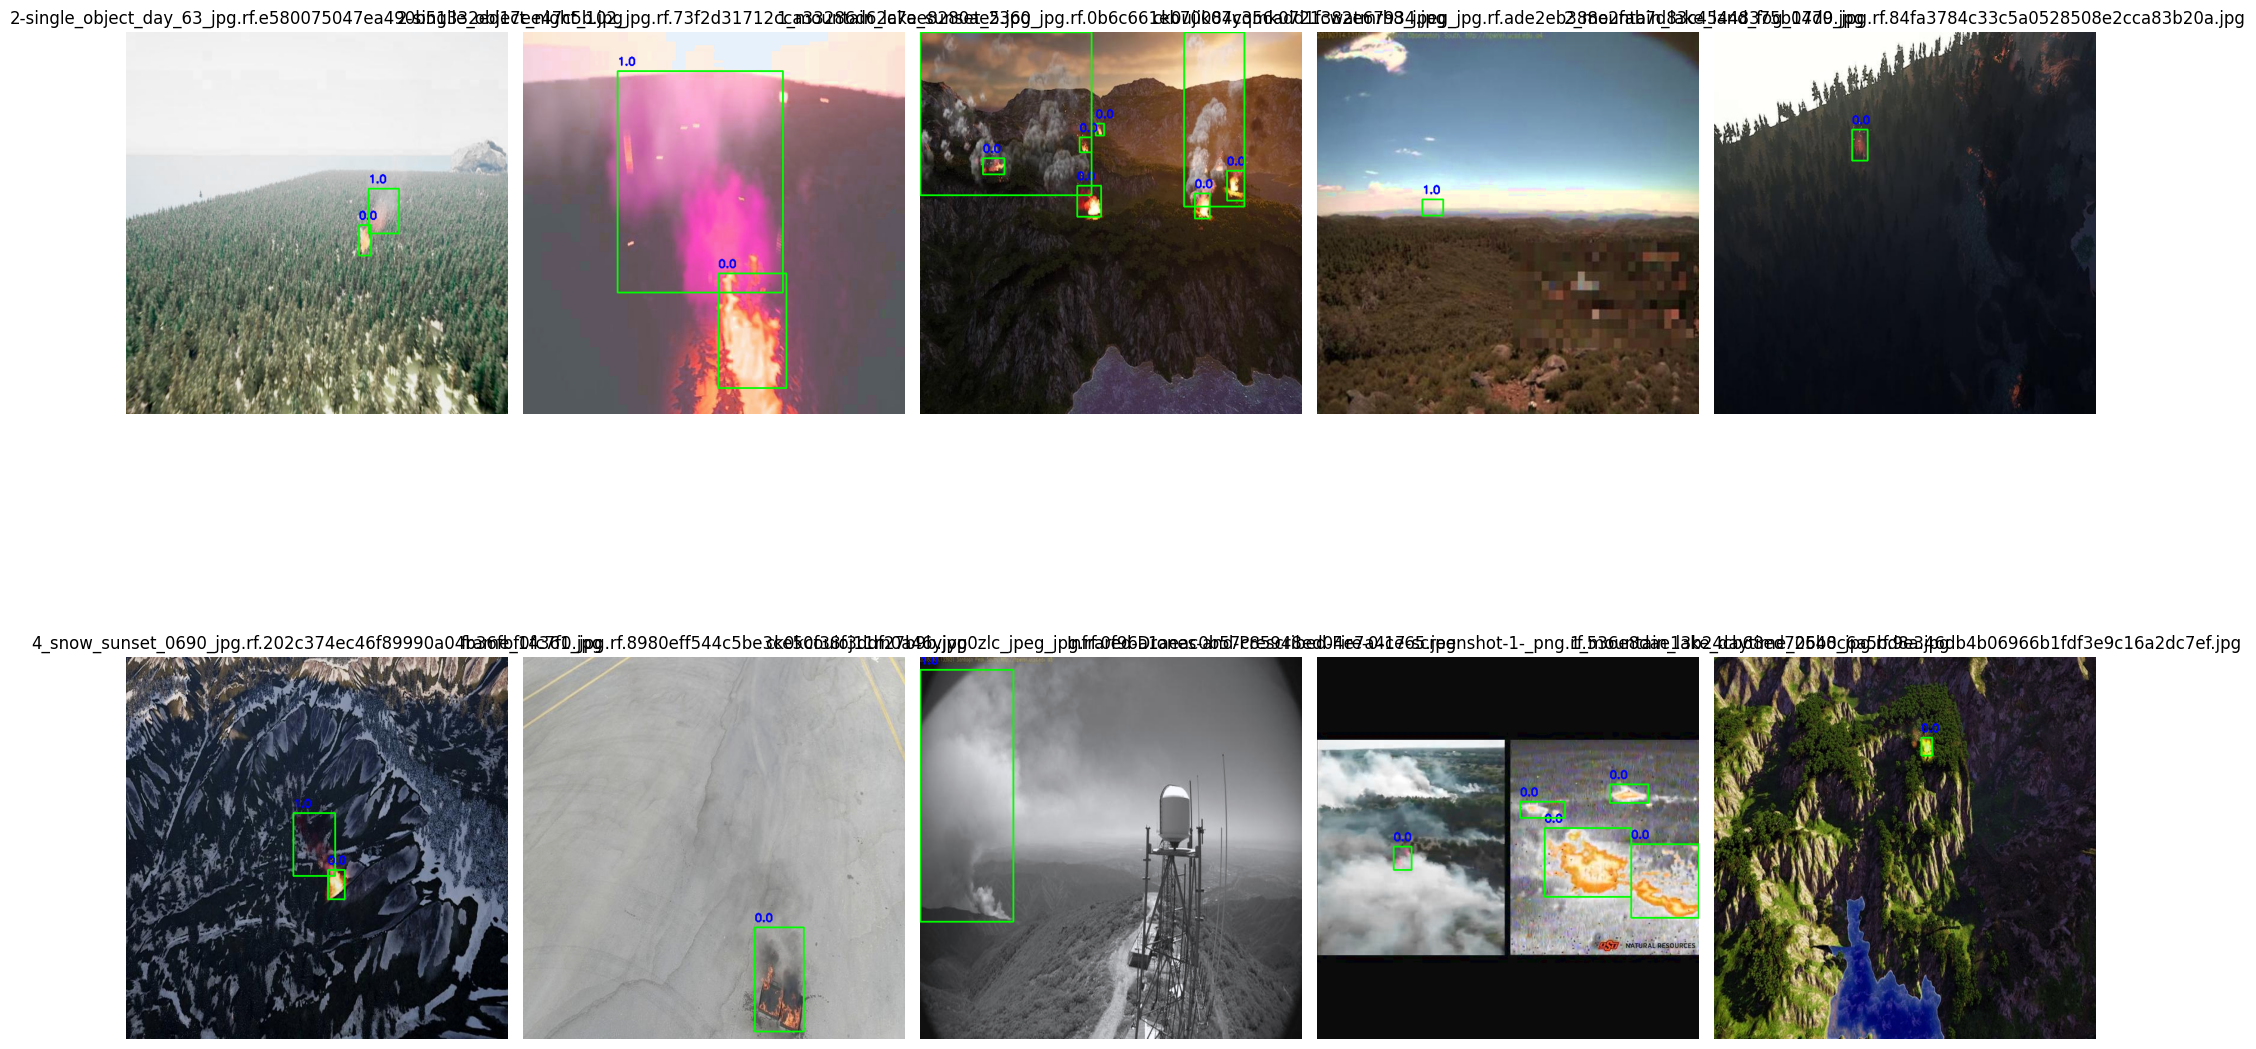

In [7]:
def get_transform(resize_dim=None):
    transforms = [
        A.RandomBrightnessContrast(p=0.2),
        A.CLAHE(clip_limit=4.0, p=0.1),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),

        A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0)
    ]
    
    if resize_dim is not None:
        transforms.append(A.Resize(height=resize_dim, width=resize_dim))

    return A.Compose(
        transforms,
        bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
    )

def draw_bboxes(image, bboxes, class_labels):
    """Draw bounding boxes on image"""
    h, w = image.shape[:2]
    for (xc, yc, bw, bh), cls in zip(bboxes, class_labels):

        x1 = int((xc - bw/2) * w)
        y1 = int((yc - bh/2) * h)
        x2 = int((xc + bw/2) * w)
        y2 = int((yc + bh/2) * h)
        
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, str(cls), (x1, y1 - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    return image

def augment_and_save(img_path, out_img_dir, out_lbl_dir, transform, sample_images=None):

    lbl_path = img_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
    
    image = cv2.imread(img_path)
    h, w = image.shape[:2]

    class_labels, bboxes = [], []
    with open(lbl_path) as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.split())
            class_labels.append(int(cls))
            bboxes.append([xc, yc, bw, bh])

    augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    aug_img = augmented['image']
    aug_bboxes = augmented['bboxes']
    aug_classes = augmented['class_labels']

    aug_path = os.path.join(out_img_dir, basename)
    cv2.imwrite(aug_path, aug_img)

    if sample_images is not None and len(sample_images) < 10:
        img_with_boxes = draw_bboxes(aug_img.copy(), aug_bboxes, aug_classes)
        sample_images.append((img_with_boxes, basename))

    out_lbl = os.path.join(out_lbl_dir, basename.replace('.jpg', '.txt'))
    with open(out_lbl, 'w') as f:
        for cls, (xc, yc, bw, bh) in zip(aug_classes, aug_bboxes):
            f.write(f"{cls} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}\n")

train_img_dir = "/kaggle/working/wildfire-detection--1/train_small/images"
out_img_dir = "/kaggle/working/wildfire-detection--1/train_aug/images"
out_lbl_dir = "/kaggle/working/wildfire-detection--1/train_aug/labels"

os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_lbl_dir, exist_ok=True)

sample_images = []

resize_dim = 640
transform = get_transform(resize_dim)

img_paths = glob(os.path.join(train_img_dir, "*.jpg"))
for img_path in img_paths:
    augment_and_save(img_path, out_img_dir, out_lbl_dir, transform, sample_images)

plt.figure(figsize=(20, 15))
for i, (img, title) in enumerate(sample_images[:10], 1):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, i)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:

model = YOLO('/kaggle/input/yolovs/best.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
filepath = '/kaggle/working/runs/detect/fire_detection_small/weights/best.pt'

try:
    link = FileLink(filepath)
    display(link)
except FileNotFoundError:
    print(f"Error: File not found at {filepath}. Make sure your notebook is committed and the path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")

/kaggle/working/runs/detect/fire_detection_small/weights/best.pt

In [10]:
!pip install mean_average_precision

In [11]:
model_name = "openai/clip-vit-base-patch32"
device     = "cuda" if torch.cuda.is_available() else "cpu"

clip_model = CLIPModel.from_pretrained(model_name).to(device)
processor  = CLIPProcessor.from_pretrained(model_name)

alpha            = 0.6   
beta             = 0.4   
fusion_threshold = 0.4   

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

## Making a new baseline for clip as the dataset was changed

In [78]:
base_path = CONFIG["base_path"]
test_img_dir = os.path.join(base_path, 'test_small', 'images')
test_lbl_dir = os.path.join(base_path, 'test_small', 'labels')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

mean = processor.image_processor.image_mean
std = processor.image_processor.image_std
clip_preprocess = Compose([
    Resize((224, 224), interpolation=Image.BICUBIC),
    ToTensor(),
    Normalize(mean=mean, std=std)
])

fire_prompts = ["fire or smoke image"]

nonfire_prompts = ["Nofire image"]

def get_text_embeds(texts):
    inp = processor(text=texts, return_tensors='pt', padding=True).to(device)
    with torch.no_grad():
        emb = clip_model.get_text_features(**inp)
    return F.normalize(emb, dim=-1)

fire_embeds = get_text_embeds(fire_prompts)       
nonfire_embeds = get_text_embeds(nonfire_prompts)  

def classify_with_prompts(crop: Image.Image, threshold=0.5):
    """Returns label and score using only prompt-based classification."""
    img_tensor = clip_preprocess(crop).unsqueeze(0).to(device)
    with torch.no_grad():
        img_feat = clip_model.get_image_features(pixel_values=img_tensor)
    img_feat = F.normalize(img_feat, dim=-1)  

    fire_sim = (img_feat @ fire_embeds.T).squeeze(0).mean().item()
    nonfire_sim = (img_feat @ nonfire_embeds.T).squeeze(0).mean().item()

    prob = fire_sim / (fire_sim + nonfire_sim + 1e-6)
    label = "FIRE" if prob >= threshold else "NON-FIRE"
    return label, prob

def evaluate_clip_model(test_img_dir, test_lbl_dir):
    y_true, y_pred = [], []
    image_files = [f for f in os.listdir(test_img_dir) if f.endswith('.jpg')]

    for img_name in tqdm(image_files, desc="Evaluating test images"):
        img_path = os.path.join(test_img_dir, img_name)
        lbl_path = os.path.join(test_lbl_dir, img_name.replace('.jpg', '.txt'))

        ground_truth = 1 if os.path.exists(lbl_path) and len(open(lbl_path).readlines()) > 0 else 0

        img = Image.open(img_path).convert('RGB')
        label, _ = classify_with_prompts(img)

        pred = 1 if label == "FIRE" else 0
        y_true.append(ground_truth)
        y_pred.append(pred)

    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

accuracy = evaluate_clip_model(test_img_dir, test_lbl_dir)
print(f"New Baseline Zero-Shot CLIP Accuracy: {accuracy * 100:.2f}%")


Evaluating test images: 100%|██████████| 1304/1304 [00:26<00:00, 49.80it/s]
New Baseline Zero-Shot CLIP Accuracy: 71.32%


In [49]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ahkr2tjc
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ahkr2tjc
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=907ef03b77ae841ca2554d66175bee303ff1e6042b0460c4877cebb861f41ee2
  Stored in directory: /tmp/pip-ephem-wheel-cache-no1rf4ok/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip
Note: you may need to restart the kernel to use updated packages.


## Running Yolo and Clip in the same pipeline to make inferences


Starting evaluation pipeline...


Evaluating images:   0%|          | 0/1304 [00:00<?, ?it/s]

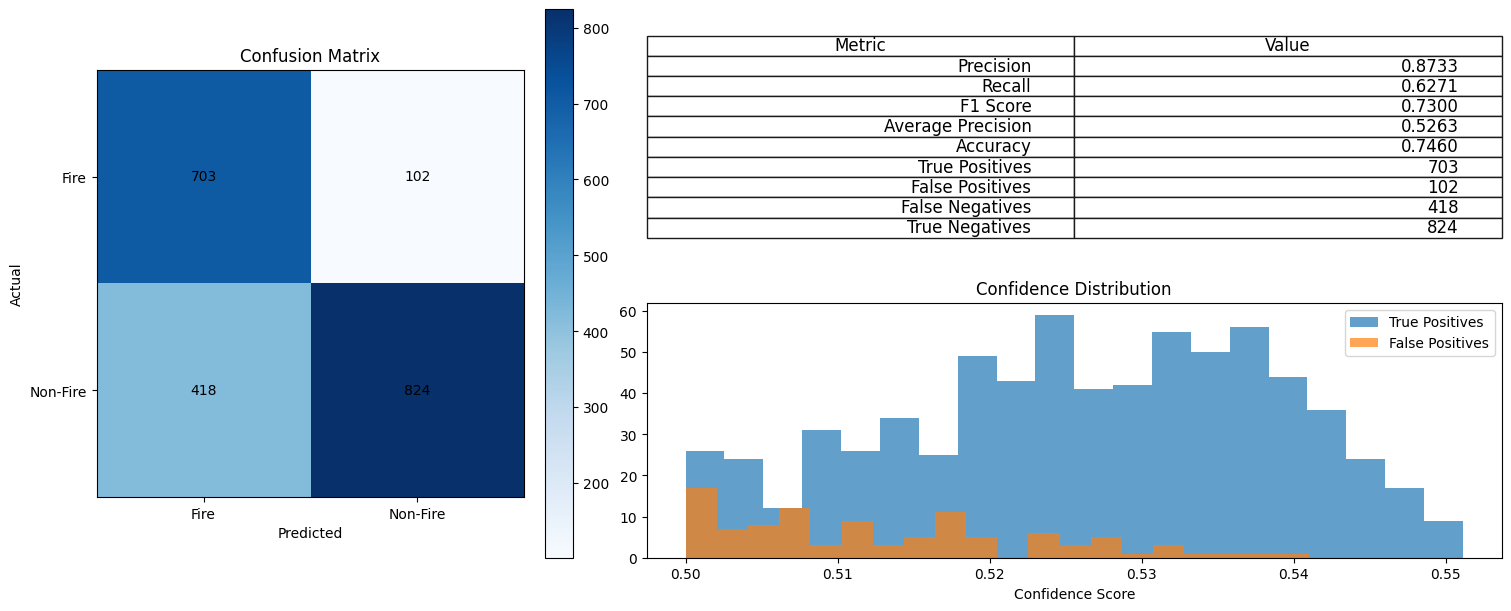


Evaluation Complete! Processed 1304 images
Final Accuracy: 0.7460


In [80]:
CONFIG = {
    "base_path": "/kaggle/working/wildfire-detection--1",
    "yolo_model_path": "/kaggle/input/yolovs/best.pt",
    "iou_threshold": 0.5,
    "fusion_weights": (0.1, 0.9),  
    "fusion_threshold": 0.5,
    "image_size": 640
}

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess_clip = clip.load("ViT-B/32", device=device)

def classify_with_context(pil_img):
    
        """Returns (predicted_label, fire_prob)"""
        img_pre = preprocess_clip(pil_img).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = clip_model.encode_image(img_pre)
            logits = logits / logits.norm(dim=-1, keepdim=True)

        fire_prompts = [
            "thick black smoke rising above trees",
            "bright orange flames engulfing vegetation",
            "glowing embers spreading in dry grass",
            "dense white smoke plume in forest",
            "red flame fronts moving through woodland",
            "sparking ignition points in dry foliage",
            "charred trees with active ground fire",
            "smoke column developing in forest area"
        ]

        no_fire_prompts = [
            "peaceful forest with no signs of combustion",
            "natural fog in mountainous woodland",
            "sunset colors mimicking fire appearance",
            "steam rising from moist forest floor",
            "dust cloud from animal movement in woods",
            "autumn leaves falling in colorful patterns",
            "cloud shadows creating dark forest patches",
            "insect swarms resembling smoke patterns"
        ]

        fire_tokens = clip.tokenize(fire_prompts).to(device)
        no_fire_tokens = clip.tokenize(no_fire_prompts).to(device)

        text_features_fire = clip_model.encode_text(fire_tokens)
        text_features_fire = text_features_fire / text_features_fire.norm(dim=-1, keepdim=True)

        text_features_nofire = clip_model.encode_text(no_fire_tokens)
        text_features_nofire = text_features_nofire / text_features_nofire.norm(dim=-1, keepdim=True)

        text_features = torch.cat([text_features_fire.mean(dim=0, keepdim=True),
                           text_features_nofire.mean(dim=0, keepdim=True)], dim=0)


        probs = (logits @ text_features.T).softmax(dim=-1).squeeze()

        idx = torch.argmax(probs).item()
        label = "fire" if idx == 0 else "no fire"
        return label, probs[0].item()  

def read_yolo_labels(label_file):
    with open(label_file, 'r') as f:
        return [tuple(map(float, line.strip().split())) for line in f.readlines()]

def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2
    xi1, yi1 = max(x1, x1g), max(y1, y1g)
    xi2, yi2 = min(x2, x2g), min(y2, y2g)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    union_area = (x2 - x1) * (y2 - y1) + (x2g - x1g) * (y2g - y1g) - inter_area
    return inter_area / union_area if union_area > 0 else 0.0

def yolo_to_pixels(box, img_w, img_h):
    x_c, y_c, w, h = box
    x1 = (x_c - w / 2) * img_w
    y1 = (y_c - h / 2) * img_h
    x2 = (x_c + w / 2) * img_w
    y2 = (y_c + h / 2) * img_h
    return (x1, y1, x2, y2)

def setup_environment():
    paths = {
        "gt_labels": os.path.join(CONFIG["base_path"], 'test_small', 'labels'),
        "images": os.path.join(CONFIG["base_path"], 'test_small', 'images')
    }
    for path in paths.values():
        if not os.path.exists(path):
            raise FileNotFoundError(f"Path not found: {path}")
    samples = glob.glob(os.path.join(paths["images"], '*.jpg'))
    if not samples:
        raise FileNotFoundError("No test images found")
    return paths, samples

def initialize_models():
    return YOLO(CONFIG["yolo_model_path"])

def evaluate_pipeline(yolo_model, clip_func, paths, samples):
    stats = defaultdict(list)
    alpha, beta = CONFIG["fusion_weights"]

    for img_path in tqdm(samples, desc="Evaluating images"):
        base = os.path.splitext(os.path.basename(img_path))[0]
        gt_file = os.path.join(paths["gt_labels"], f"{base}.txt")
        gt_boxes = []
        if os.path.exists(gt_file):
            for cls, *box in read_yolo_labels(gt_file):
                if cls == 0:
                    gt_boxes.append(yolo_to_pixels(box, CONFIG["image_size"], CONFIG["image_size"]))

        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        res = yolo_model.predict(img_path, conf=0.05, imgsz=CONFIG["image_size"], verbose=False)[0]
        detections = []
        for (x1,y1,x2,y2), conf, cls in zip(res.boxes.xyxy.cpu(), res.boxes.conf.cpu(), res.boxes.cls.cpu()):
            if int(cls) != 0: continue
            crop = Image.fromarray(img[int(y1):int(y2), int(x1):int(x2)])
            _, clip_score = clip_func(crop)
            fused = alpha * conf.item() + beta * clip_score
            if fused > CONFIG["fusion_threshold"]:
                detections.append(((x1.item(), y1.item(), x2.item(), y2.item()), fused))

        matched = set()
        for box, score in detections:
            best_iou, best_idx = 0, -1
            for idx, gt in enumerate(gt_boxes):
                if idx in matched: continue
                iou = calculate_iou(box, gt)
                if iou > best_iou:
                    best_iou, best_idx = iou, idx
            if best_iou >= CONFIG["iou_threshold"]:
                stats['true_positives'].append(score)
                matched.add(best_idx)
            else:
                stats['false_positives'].append(score)

        stats['false_negatives'].extend([1] * (len(gt_boxes) - len(matched)))
        if not gt_boxes and not detections:
            stats['true_negatives'].append(1)

    return stats

def calculate_metrics(stats):
    tp = len(stats['true_positives'])
    fp = len(stats['false_positives'])
    fn = len(stats['false_negatives'])
    tn = len(stats['true_negatives'])
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    avg_prec = np.mean(stats['true_positives']) if stats['true_positives'] else 0.0
    acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else 0.0
    return {
        'precision': precision, 'recall': recall, 'f1_score': f1,
        'average_precision': avg_prec, 'accuracy': acc,
        'true_positives': tp, 'false_positives': fp,
        'false_negatives': fn, 'true_negatives': tn
    }

def visualize_results(stats):
    metrics = calculate_metrics(stats)
    fig = plt.figure(figsize=(15, 6), constrained_layout=True)
    gs = fig.add_gridspec(2, 3)

    ax1 = fig.add_subplot(gs[:, 0])
    cm = np.array([[metrics['true_positives'], metrics['false_positives']],
                   [metrics['false_negatives'], metrics['true_negatives']]])
    im = ax1.imshow(cm, cmap='Blues')
    for i in range(2):
        for j in range(2):
            ax1.text(j, i, f"{cm[i,j]}", ha='center', va='center')
    ax1.set_xticks([0, 1])
    ax1.set_yticks([0, 1])
    ax1.set_xticklabels(['Fire', 'Non-Fire'])
    ax1.set_yticklabels(['Fire', 'Non-Fire'])
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    plt.colorbar(im, ax=ax1)

    ax2 = fig.add_subplot(gs[0, 1:])
    ax2.axis('off')
    table_data = [[k.replace("_", " ").title(), f"{v:.4f}" if isinstance(v, float) else str(v)]
                  for k, v in metrics.items()]
    table = ax2.table(cellText=table_data, colLabels=["Metric", "Value"], loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)

    ax3 = fig.add_subplot(gs[1, 1:])
    if stats['true_positives']:
        ax3.hist(stats['true_positives'], bins=20, alpha=0.7, label='True Positives')
    if stats['false_positives']:
        ax3.hist(stats['false_positives'], bins=20, alpha=0.7, label='False Positives')
    ax3.set_xlabel('Confidence Score')
    ax3.set_title('Confidence Distribution')
    ax3.legend()
    plt.show()
    return metrics

if __name__ == "__main__":
    try:
        paths, samples = setup_environment()
        yolo_model = initialize_models()
        print("\nStarting evaluation pipeline...")
        stats = evaluate_pipeline(yolo_model, classify_with_context, paths, samples)
        metrics = visualize_results(stats)
        print(f"\nEvaluation Complete! Processed {len(samples)} images")
        print(f"Final Accuracy: {metrics['accuracy']:.4f}")
    except Exception as e:
        print(f"\nError in evaluation pipeline: {str(e)}")

### Using better prompts and combing Yolo and Clip gives us a better accuracy as compared to normal clip.